# Combinatorics: Count non trivial dead graphs of Nest (example below)

In [2]:

import numpy as np
from numba.typed import Dict, List
from numba import njit
from anonymigraph.anonymization._external.nest_model.fast_rewire import create_neighborhood_dict, get_block_indices
from anonymigraph.anonymization._external.nest_model.fast_rewire import (
    get_block_indices,
    sort_edges,
)

def count_dead_subgraph(edges, colors):
    edges_ordered, edges_classes, dead_arr, is_mono = sort_edges(edges, colors, is_directed=False)
    block_indices = get_block_indices(edges_classes, dead_arr)

    old_alive_total_color_subgraphs, true_additional_dead_color_subgraphs = _count_dead_subgraph(
        edges_ordered,
        edges_classes[:, 0],
        is_mono[0],
        block_indices[0],
    )

    num_colors = np.unique(colors).size
    all_possible_color_subgraphs = num_colors * (num_colors + 1) // 2
    color_subgraphs_with_edges = np.unique(edges_classes[:, 0]).size

    return all_possible_color_subgraphs, color_subgraphs_with_edges, old_alive_total_color_subgraphs, true_additional_dead_color_subgraphs

#@njit(cache=True)
def _count_dead_subgraph(edges, edge_class, is_mono_color, block):
    old_alive_total_subgraphs = 0
    true_additional_dead_subgraphs = 0
    old_additional_dead_subgraphs = 0

    for i in range(len(block)):
        lower = block[i, 0]
        upper = block[i, 1]
        current_class = edge_class[lower]
        block_edges = edges[lower:upper]

        if is_mono_color.get(current_class, False):
            any_swaps_possible = _is_there_any_edge_swap_possible_mono(block_edges)
        else:
            any_swaps_possible = _is_there_any_edge_swap_possible_bipartite(block_edges)

        if not any_swaps_possible:
            true_additional_dead_subgraphs += 1

        if np.unique(block_edges[:, 0]).size == 1 or np.unique(block_edges[:, 1]).size == 1:
            old_additional_dead_subgraphs += 1 # there

        old_alive_total_subgraphs += 1


    assert old_additional_dead_subgraphs <= 2 # this is a bug the last or first block is not correctly assigned as dead this should be 0 really

    return old_alive_total_subgraphs, true_additional_dead_subgraphs


@njit(cache=True)
def _is_there_any_edge_swap_possible_mono(edges):
    num_edges = len(edges)
    neigh = create_neighborhood_dict(edges)

    for index1 in range(num_edges):
        for index2 in range(num_edges):
            if index1 == index2:
                continue
            for i2_1 in range(2):
                i2_1 = np.random.randint(0, 2)
                i2_2 = 1 - i2_1
                e1_l, e1_r = edges[index1, :]
                e2_l = edges[index2, i2_1]
                e2_r = edges[index2, i2_2]

                if (e1_r == e2_r) or (e1_l == e2_l):  # swap would do nothing
                    continue

                if (e1_l == e2_r) or (e1_r == e2_l):  # no self loops after swap
                    continue

                if e2_r in neigh[e1_l] or e1_r in neigh[e2_l]:
                    # we cant swap
                    pass
                else:
                    # we can swap
                    return True
    # no swaps at all
    return False

@njit(cache=True)
def _is_there_any_edge_swap_possible_bipartite(edges):
    """Rewires a bipartite network specified in edges

    This is optimized for larger networks and uses a dictionary lookup to avoid multi edges
    """

    delta = len(edges)
    neigh = Dict()
    neigh[0] = List([-1])
    del neigh[0]
    for l, r in edges:
        if l not in neigh:
            tmp = List([-1])
            tmp.pop()
            neigh[l] = tmp
        neigh[l].append(r)

    for index1 in range(delta):
        for index2 in range(delta):
            if index1 == index2:
                continue
            e1_l, e1_r = edges[index1, :]
            e2_l, e2_r = edges[index2, :]

            if (e1_r == e2_r) or (e1_l == e2_l):  # swap would do nothing
                continue

            if (e1_l == e2_r) or (e1_r == e2_l):  # no self loops after swap
                continue

            if e2_r in neigh[e1_l] or e1_r in neigh[e2_l]:
                # we cant swap
                pass
            else:
                # we can swap
                return True
    # no swaps at all
    return False


- the graph below contains no valid edge swaps even though it is not classified as "dead" by original nest. This is infact a complex combinatorial problem that heavily complicates stochastic approaches to analyze nest

possible color subgraphs: 3 of those non-empty: 1 of those are alive by org nest: 1 of those are additional dead: 1


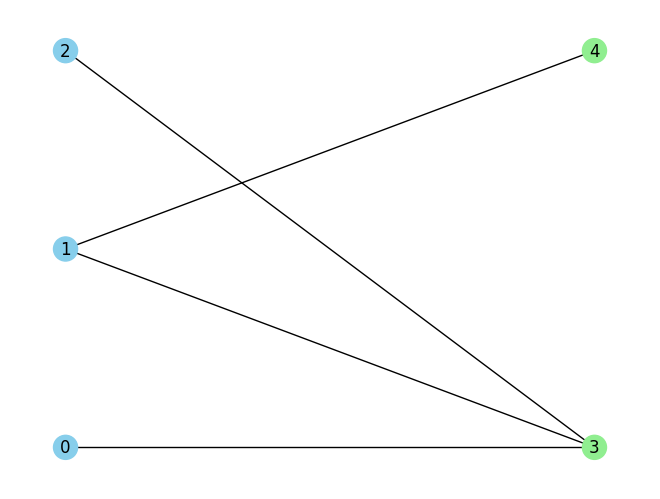

In [3]:
import networkx as nx
import numpy as np

G = nx.Graph()
G.add_nodes_from([0, 1, 2], bipartite=0)  # Group 1
G.add_nodes_from([3, 4], bipartite=1)    # Group 2
G.add_edges_from([(0, 3), (1, 3), (2, 3), (1, 4)])

colors = np.array([0,0,0,1,1])

edges = np.array(G.edges(), dtype=np.uint32)

all_possible_color_subgraphs, color_subgraphs_with_edges, old_alive_total_color_subgraphs, true_additional_dead_color_subgraphs = count_dead_subgraph(edges, colors.reshape(1, -1))
print(f"possible color subgraphs: {all_possible_color_subgraphs} of those non-empty: {color_subgraphs_with_edges} of those are alive by org nest: {old_alive_total_color_subgraphs} of those are additional dead: {true_additional_dead_color_subgraphs}")

pos = nx.bipartite_layout(G, [0,1,2])
nx.draw(G, pos, with_labels=True, node_color=['skyblue' if node in [0,1,2] else 'lightgreen' for node in G.nodes()])

# Define Graph Bound / Convergence tool for graphs

In [4]:
from scipy.sparse.linalg import eigsh

def largest_eigen(A, num_iters=None, tol=None):
    if num_iters is None:
        num_iters = float('inf')  # By default only stop once tolerance criteria is met
    if tol is None:
        tol = 1e-12

    n = A.shape[0]  # Size of the matrix
    vec = np.ones(n)  # Starting with a constant vector

    iter_count = 0  # Initialize iteration counter
    while iter_count < num_iters:  # Loop until num_iters or convergence
        vec_next = A @ vec + vec
        norm = np.linalg.norm(vec_next)
        vec_diff = vec_next / norm - vec
        vec = vec_next / norm

        # Check for convergence
        if np.linalg.norm(vec_diff) < tol:
            break

        # Warn if exceeding 10,000 iterations
        if iter_count == 10000:
            print("Iteration count exceeded 10,000. Consider increasing tolerance or checking the matrix for convergence properties.")
        if iter_count == 100000:
            print("Iteration count exceeded 100,000. Consider increasing tolerance or checking the matrix for convergence properties.")
        if iter_count == 1000000:
            print("Iteration count exceeded 1,000,000. Consider increasing tolerance or checking the matrix for convergence properties.")

        iter_count += 1

    eigenvalue = (vec.T @ (A @ vec)) / (vec.T @ vec)  # Rayleigh quotient for eigenvalue

    if not np.all(vec > 0):
        raise ValueError("The adjusted eigenvector does not have all positive entries.")

    return eigenvalue, vec


def largest_eigen_integer(A, num_iters=1890*10, tol=None):
    n = A.shape[0]  # Size of the matrix
    vec = np.ones(n, dtype=object)  # Use dtype=object for arbitrary-precision integers

    for _ in range(num_iters):
        vec_next = A.dot(vec) + vec  # Sparse matrix-vector multiplication + integer addition
        # Normalization and convergence checks are challenging with integers and may need adjustment

        vec = vec_next  # Placeholder, actual normalization to be adjusted

    # Estimating eigenvalue with integers requires careful handling, possibly via Rayleigh quotient approximation

    return vec

def eigen_gap(A):
    val, _ = eigsh(A, k=2, which='LA')
    return val[1] - val[0]

def k_biggest_ev(A, k=1):
    val, _ = eigsh(A, k=k, which='LA')
    return val

def get_delta(A, lam, x):
    return A @ x - lam * x

def calculate_kmeans_cluster_loss(x, cluster_labels, centroids, mode=2):
    assert mode == 2
    total_loss = 0
    for i, color in enumerate(cluster_labels):
        centroid = centroids[color]
        distance = (x[i] - centroid) ** 2
        total_loss += distance
    return np.sqrt(total_loss)

In [5]:
from anonymigraph.anonymization._external.nest_model._rewire import _rewire
import optimal1dclustering

from anonymigraph.anonymization._external.nest_model.fast_wl import WL_fast

def get_convergence_data_of_nest(G, min_cluster_size = 1, printing = False, max_k = float("Inf"), max_iter=None, tol=None, random_seed=44):
    if not nx.is_connected(G):
        raise ValueError("G is not connected, spectral gap may be 0 nothing holds anymore.")
    A_G = nx.adjacency_matrix(G).astype(np.float64)  # Get the adjacency matrix as a sparse matrix
    lam_G, x = largest_eigen(A_G, max_iter, tol)
    _, max_degree = max(G.degree(), key=lambda pair: pair[1])
    spectral_gap = eigen_gap(A_G)

    print("Dominant eigenvalue:", lam_G)
    print("max_degree:", max_degree)
    print("spectral_gap", spectral_gap)

    data_dict = {}
    for k in range(1, min(G.number_of_nodes()//min_cluster_size, max_k)):
        results = {}
        mode = 2
        colors, centroids = optimal1dclustering.cluster(
            x, k, mode=mode, min_cluster_size=min_cluster_size
        )
        colors = np.array(colors)
        clusterLoss = calculate_kmeans_cluster_loss(x, colors, centroids, mode = mode)

        # Get new synthetic graph with Variation Nest
        edges = np.array(G.edges(), dtype=np.uint32)
        edges_rewired = _rewire(edges, colors.reshape(1, -1), r=10, parallel=False, random_seed=random_seed) # r=10 to ensure we really did enough flips to be burned in
        Ga = nx.Graph()
        Ga.add_nodes_from(G.nodes(data=True))
        Ga.add_edges_from(edges_rewired)

        # dead subgraph statistics
        is_G_a_connected = int(nx.is_connected(Ga))
        all_possible_color_subgraphs, color_subgraphs_with_edges, old_alive_total_color_subgraphs, true_additional_dead_color_subgraphs = count_dead_subgraph(edges, colors.reshape(1, -1))

        # Get graph spectrum statistics
        A_Ga = nx.adjacency_matrix(Ga).astype(np.float64)
        delta = get_delta(A_Ga, lam_G, x)
        delta_norm = np.linalg.norm(delta)
        lam_Ga, x_Ga = largest_eigen(A_Ga, max_iter, tol)
        eigenvec_diff_norm = np.linalg.norm(x - x_Ga)

        #eigenvec_diff_norm_bound = 2*max_degree*clusterLoss / spectral_gap # provable approx upper bound
        eigenvec_diff_norm_bound = 2*lam_G*clusterLoss / spectral_gap # approx approx upper bound
        #eigenvec_diff_norm_bound = lam_G*clusterLoss / spectral_gap # probably approx uppper bound tight

        if eigenvec_diff_norm > eigenvec_diff_norm_bound and k > 4 and is_G_a_connected == 1:
            print("BREAKPOINT")
            print("BREAKPOINT")
            """
            graph = G
            color_by = x
            import matplotlib.pyplot as plt
            from matplotlib.colors import Normalize
            plt.figure(dpi=300)
            norm = Normalize(vmin=color_by.min(), vmax=color_by.max())
            cmap = plt.cm.get_cmap('inferno')
            pos = nx.circular_layout(graph)
            #pos = nx.spring_layout(graph, iterations = 1000)
            nx.draw(graph, pos, with_labels=False, font_size=3, node_size=7, node_color="white")
            for i, (node, color_val) in enumerate(zip(graph.nodes, color_by)):
                plt.text(pos[node][0], pos[node][1], str(node), fontsize=3, ha='center', va='center', color=cmap(norm(color_val)))
                #plt.text(pos[node][0], pos[node][1], str(node), fontsize=3, ha='center', va='center', color=cmap(norm(color_val)))
            plt.show()
            """

        # Saving stats
        results['all_possible_color_subgraphs'] = all_possible_color_subgraphs
        results['color_subgraphs_with_edges'] = color_subgraphs_with_edges
        results['old_alive_total_color_subgraphs'] = old_alive_total_color_subgraphs
        results['true_additional_dead_color_subgraphs'] = true_additional_dead_color_subgraphs
        results['is_G_a_connected'] = is_G_a_connected

        results['Clustering Loss'] = clusterLoss
        results['Delta L2 Magnitude'] = delta_norm
        results['Delta L2 Magnitude / Lambda_G'] = delta_norm/lam_G
        results['Eigenvec L2 Norm Diff'] = eigenvec_diff_norm
        results['Eigenvec L2 Norm Diff Bound'] = eigenvec_diff_norm_bound
        results['Dominant Lambda Diff'] = lam_Ga - lam_G

        data_dict[k] = results

        if printing:
            print("-"*30)
            print(f"{k}: Clustering Loss", clusterLoss)
            print(f"{k}: possible color subgraphs: {all_possible_color_subgraphs} of those non-empty: {color_subgraphs_with_edges} of those are alive by org nest: {old_alive_total_color_subgraphs} of those are additional dead: {true_additional_dead_color_subgraphs}")

            print(f"{k}: Eigenvec L2 Norm Diff:", eigenvec_diff_norm)
            print(f"{k}: Eigenvec L2 Norm Diff Bound:", eigenvec_diff_norm_bound)
            print(f"{k}: Delta L2 Magnitude", delta_norm)
            print(f"{k}: Delta L2 Magnitude / Lambda_G", delta_norm/lam_G)
            print(f"{k}: Dominant Lambda Diff:", lam_Ga - lam_G)
            print(f"{k}: is_G_a_connected:", is_G_a_connected)
        else:
            print(f"{k}:")


    edges = np.array(G.edges(), dtype=np.uint32)
    bidirectional_edges = np.row_stack((edges, edges[:, [1, 0]]))
    all_depth_colors = WL_fast(bidirectional_edges, labels=None, max_iter=None)

    print(f"Calculating Performance of Original Nest, with {len(all_depth_colors)} depths")
    original_nest = {}
    for i in range(len(all_depth_colors)):

        print(f"{i}: Calculating Nest at depth {i}")

        colors = all_depth_colors[i].reshape(1, -1)
        edges_rewired = _rewire(
            edges, colors, r=10, parallel=False, random_seed=random_seed # r=10 to ensure we really did enough flips to be burned in
        )
        k_approx = len(np.unique(colors))
        if k_approx > max_k:
            continue

        Ga = nx.Graph()
        Ga.add_nodes_from(G.nodes(data=True))
        Ga.add_edges_from(edges_rewired)

        A_Ga = nx.adjacency_matrix(Ga).astype(np.float64)
        lam_Ga, x_Ga = largest_eigen(A_Ga, max_iter, tol)
        eigenvec_diff_norm = np.linalg.norm(x - x_Ga)

        results = {}
        results['Eigenvec L2 Norm Diff'] = eigenvec_diff_norm

        original_nest[k_approx] = results


    return {"data_dict": data_dict, "original_nest":original_nest}


import plotly.graph_objects as go

def plot_convergence_data(data, title, plot_nest=True):
    data_dict = data["data_dict"]

    # Create traces for each metric
    traces = []
    traces.append(go.Scatter(x=list(data_dict.keys()),
                                    y=[data_dict[k]['Clustering Loss'] for k in data_dict.keys()],
                                    mode='lines',#+markers',
                                    name=r'$\ell$'))
    #traces.append(go.Scatter(x=list(data_dict.keys()),
    #                            y=[data_dict[k]['Delta L2 Magnitude'] for k in data_dict.keys()],
    #                            mode='lines+markers',
    #                            name='Delta L2 Magnitude'))
    #traces.append(go.Scatter(x=list(data_dict.keys()),
    #                            y=[data_dict[k]['Delta L2 Magnitude / Lambda_G'] for k in data_dict.keys()],
    #                            mode='lines+markers',
    #                            name='Delta L2 Magnitude / Lambda_G'))
    #traces.append(go.Scatter(x=list(data_dict.keys()),
    #                             y=[data_dict[k]['Dominant Lambda Diff'] for k in data_dict.keys()],
    #                             mode='lines+markers',
    #                             name='Dominant Lambda Diff'))
    traces.append(go.Scatter(x=list(data_dict.keys()),
                                    y=[data_dict[k]['Eigenvec L2 Norm Diff'] for k in data_dict.keys()],
                                    mode='lines',#+markers',
                                    name=r'$\left\Vert v_1 - v`_1\right\Vert_2$'))
    traces.append(go.Scatter(x=list(data_dict.keys()),
                                    y=[data_dict[k]['Eigenvec L2 Norm Diff Bound'] for k in data_dict.keys()],
                                    mode='lines',#+markers',
                                    name=r'$\textrm{Bound on }\left\Vert v_1 - v`_1\right\Vert_2\textrm{ first order perturbation}$'))

    traces.append(go.Scatter(x=list(data_dict.keys()),
                            y=[data_dict[k]['color_subgraphs_with_edges'] for k in data_dict.keys()],
                            mode='lines',#+markers',
                            name='Color Subgraphs with edges',
                            yaxis='y2'))  # This assigns the trace to the second y-axis

    traces.append(go.Scatter(x=list(data_dict.keys()),
                            y=[data_dict[k]['old_alive_total_color_subgraphs'] for k in data_dict.keys()],
                            mode='lines',#+markers',
                            name='non-dead color subgraphs (as defined in original nest)',
                            yaxis='y2'))  # This assigns the trace to the second y-axis

    traces.append(go.Scatter(x=list(data_dict.keys()),
                            y=[data_dict[k]['true_additional_dead_color_subgraphs'] for k in data_dict.keys()],
                            mode='lines',#+markers',
                            name='Additional dead color subgraphs',
                            yaxis='y2'))  # This assigns the trace to the second y-axis

    traces.append(go.Scatter(x=list(data_dict.keys()),
                            y=[data_dict[k]['is_G_a_connected'] for k in data_dict.keys()],
                            mode='lines',#+markers',
                            name='1 if sampled graph is connected',
                            yaxis='y2'))  # This assigns the trace to the second y-axis

    if plot_nest:
        original_nest = data["original_nest"]

        traces.append(go.Scatter(x=list(original_nest.keys()),
                y=[original_nest[k]['Eigenvec L2 Norm Diff'] for k in original_nest.keys()],
                mode='markers',
                name="Original Nest k=len(wl-colors)",
                marker=dict(symbol='x', size=10)))

    layout_loglog = go.Layout(title=title,
                            xaxis_title='k',
                            yaxis_title='Metric Values (Log Scale)',
                            yaxis_type='log',  # Set y-axis to log scale
                            # Add a second y-axis to the layout
                            yaxis=dict(
                                exponentformat='e',  # Use scientific notation for the primary y-axis
                            ),
                            yaxis2=dict(title='Color Subgraph Count Metrics',
                                        titlefont=dict(color='rgba(148, 103, 189, 1)'),
                                        tickfont=dict(color='rgba(148, 103, 189, 1)'),
                                        overlaying='y',  # This places the second y-axis on top of the first
                                        side='right',  # This places the second y-axis on the right
                                        type='linear'),  # Set the second y-axis to linear scale
                            hovermode='closest',
                            height=900,
                            legend=dict(
                                    orientation="h",
                                    x=0.5,
                                    y=-0.1,
                                    xanchor="center",
                                    yanchor="top"
                                )
                            )




    # Add the new trace to the figure
    fig = go.Figure(data=traces, layout=layout_loglog)
    fig.layout.template = 'simple_white+gridon' # 'presentation'

    fig.show()


# LFR graphs exponential degree sequence

In [6]:
# Get a Graph
n = 400
tau1 = 3
tau2 = 1.5
mu = 0.1
G = nx.LFR_benchmark_graph(
    n, tau1, tau2, mu, average_degree=10, min_community=80, seed=10
)
G.remove_edges_from(nx.selfloop_edges(G))

data_dict = get_convergence_data_of_nest(G, min_cluster_size = 1, max_k=400)
plot_convergence_data(data_dict, f"LFR Graph: n={n}, τ1={tau1}, τ2={tau2}, μ={mu}, AvgDeg=10, MinComm=80")

Dominant eigenvalue: 22.100950910040158
max_degree: 165
spectral_gap 6.38190340641658
1:
2:
3:


4:
5:
6:
7:
8:
9:
10:
11:
12:
13:
14:
15:
16:
17:
18:
19:
20:
21:
22:
23:
24:
25:
26:
27:
28:
29:
30:
31:
32:
33:
34:
35:
36:
37:
38:
39:
40:
41:
42:
43:
44:
45:
46:
47:
48:
49:
50:
51:
52:
53:
54:
55:
56:
57:
58:
59:
60:
61:
62:
63:
64:
65:
66:
67:
68:
69:
70:
71:
72:
73:
74:
75:
76:
77:
78:
79:
80:
81:
82:
83:
84:
85:
86:
87:
88:
89:
90:
91:
92:
93:
94:
95:
96:
97:
98:
99:
100:
101:
102:
103:
104:
105:
106:
107:
108:
109:
110:
111:
112:
113:
114:
115:
116:
117:
118:
119:
120:
121:
122:
123:
124:
125:
126:
127:
128:
129:
130:
131:
132:
133:
134:
135:
136:
137:
138:
139:
140:
141:
142:
143:
144:
145:
146:
147:
148:
149:
150:
151:
152:
153:
154:
155:
156:
157:
158:
159:
160:
161:
162:
163:
164:
165:
166:
167:
168:
169:
170:
171:
172:
173:
174:
175:
176:
177:
178:
179:
180:
181:
182:
183:
184:
185:
186:
187:
188:
189:
190:
191:
192:
193:
194:
195:
196:
197:
198:
199:
200:
201:
202:
203:
204:
205:
206:
207:
208:
209:
210:
211:
212:
213:
214:
215:
216:
217:
218:
219:
220:
221:
222:
223:
22

# Erdos Renyis

In [7]:
p = 0.05
n = 150
G = nx.erdos_renyi_graph(n, p)
data_dict = get_convergence_data_of_nest(G, min_cluster_size = 1, max_k = 150)
plot_convergence_data(data_dict, f"Erdős-Rényi: n={n}, p={p}")

Dominant eigenvalue: 8.42102347688497
max_degree: 14
spectral_gap 3.317199809096696
1:
2:
3:
4:
5:
6:
7:
8:
9:
10:
11:
12:
13:
14:
15:
16:
17:
18:
19:
20:
21:
22:
23:
24:
25:
26:
27:
28:
29:
30:
31:
32:
33:
34:
35:
36:
37:
38:
39:
40:
41:
42:
43:
44:
45:
46:
47:
48:
49:
50:
51:
52:
53:
54:
55:
56:
57:
58:
59:
60:
61:
62:
63:
64:
65:
66:
67:
68:
69:
70:
71:
72:
73:
74:
75:
76:
77:
78:
79:
80:
81:
82:
83:
84:
85:
86:
87:
88:
89:
90:
91:
92:
93:
94:
95:
96:
97:
98:
99:
100:
101:
102:
103:
104:
105:
106:
107:
108:
109:
110:
111:
112:
113:
114:
115:
116:
117:
118:
119:
120:
121:
122:
123:
124:
125:
126:
127:
128:
129:
130:
131:
132:
133:
134:
135:
136:
137:
138:
139:
140:
141:
142:
143:
144:
145:
146:
147:
148:
149:
Calculating Performance of Original Nest, with 4 depths
0: Calculating Nest at depth 0
1: Calculating Nest at depth 1
2: Calculating Nest at depth 2
3: Calculating Nest at depth 3


In [8]:
p = 0.1
n = 150
G = nx.erdos_renyi_graph(n, p)
data_dict = get_convergence_data_of_nest(G, min_cluster_size = 1, max_k = 150)
plot_convergence_data(data_dict, f"Erdős-Rényi: n={n}, p={p}")

Dominant eigenvalue: 15.747819462789941
max_degree: 25
spectral_gap 8.724635099493721
1:
2:
3:
4:
5:
6:
7:
8:
9:
10:
11:
12:
13:
14:
15:
16:
17:
18:
19:
20:
21:
22:
23:
24:
25:
26:
27:
28:
29:
30:
31:
32:
33:
34:
35:
36:
37:
38:
39:
40:
41:
42:
43:
44:
45:
46:
47:
48:
49:
50:
51:
52:
53:
54:
55:
56:
57:
58:
59:
60:
61:
62:
63:
64:
65:
66:
67:
68:
69:
70:
71:
72:
73:
74:
75:
76:
77:
78:
79:
80:
81:
82:
83:
84:
85:
86:
87:
88:
89:
90:
91:
92:
93:
94:
95:
96:
97:
98:
99:
100:
101:
102:
103:
104:
105:
106:
107:
108:
109:
110:
111:
112:
113:
114:
115:
116:
117:
118:
119:
120:
121:
122:
123:
124:
125:
126:
127:
128:
129:
130:
131:
132:
133:
134:
135:
136:
137:
138:
139:
140:
141:
142:
143:
144:
145:
146:
147:
148:
149:
Calculating Performance of Original Nest, with 3 depths
0: Calculating Nest at depth 0
1: Calculating Nest at depth 1
2: Calculating Nest at depth 2


In [9]:
p = 0.25
n = 150
G = nx.erdos_renyi_graph(n, p)
data_dict = get_convergence_data_of_nest(G, min_cluster_size = 1, max_k = 150)
plot_convergence_data(data_dict, f"Erdős-Rényi: n={n}, p={p}")

Dominant eigenvalue: 39.24808115257698
max_degree: 57
spectral_gap 29.181061879106636
1:
2:
3:
4:
5:
6:
7:
8:
9:
10:
11:
12:
13:
14:
15:
16:
17:
18:
19:
20:
21:
22:
23:
24:
25:
26:
27:
28:
29:
30:
31:
32:
33:
34:
35:
36:
37:
38:
39:
40:
41:
42:
43:
44:
45:
46:
47:
48:
49:
50:
51:
52:
53:
54:
55:
56:
57:
58:
59:
60:
61:
62:
63:
64:
65:
66:
67:
68:
69:
70:
71:
72:
73:
74:
75:
76:
77:
78:
79:
80:
81:
82:
83:
84:
85:
86:
87:
88:
89:
90:
91:
92:
93:
94:
95:
96:
97:
98:
99:
100:
101:
102:
103:
104:
105:
106:
107:
108:
109:
110:
111:
112:
113:
114:
115:
116:
117:
118:
119:
120:
121:
122:
123:
124:
125:
126:
127:
128:
129:
130:
131:
132:
133:
134:
135:
136:
137:
138:
139:
140:
141:
142:
143:
144:
145:
146:
147:
148:
149:
Calculating Performance of Original Nest, with 3 depths
0: Calculating Nest at depth 0
1: Calculating Nest at depth 1
2: Calculating Nest at depth 2


In [10]:
p = 0.5
n = 150
G = nx.erdos_renyi_graph(n, p)
data_dict = get_convergence_data_of_nest(G, min_cluster_size = 1, max_k = 150)
plot_convergence_data(data_dict, f"Erdős-Rényi: n={n}, p={p}")

Dominant eigenvalue: 74.1708874868352
max_degree: 87
spectral_gap 62.522228828622715
1:
2:
3:
4:
5:
6:
7:
8:
9:
10:
11:
12:
13:
14:
15:
16:
17:
18:
19:
20:
21:
22:
23:
24:
25:
26:
27:
28:
29:
30:
31:
32:
33:
34:
35:
36:
37:
38:
39:
40:
41:
42:
43:
44:
45:
46:
47:
48:
49:
50:
51:
52:
53:
54:
55:
56:
57:
58:
59:
60:
61:
62:
63:
64:
65:
66:
67:
68:
69:
70:
71:
72:
73:
74:
75:
76:
77:
78:
79:
80:
81:
82:
83:
84:
85:
86:
87:
88:
89:
90:
91:
92:
93:
94:
95:
96:
97:
98:
99:
100:
101:
102:
103:
104:
105:
106:
107:
108:
109:
110:
111:
112:
113:
114:
115:
116:
117:
118:
119:
120:
121:
122:
123:
124:
125:
126:
127:
128:
129:
130:
131:
132:
133:
134:
135:
136:
137:
138:
139:
140:
141:
142:
143:
144:
145:
146:
147:
148:
149:
Calculating Performance of Original Nest, with 3 depths
0: Calculating Nest at depth 0
1: Calculating Nest at depth 1
2: Calculating Nest at depth 2


In [11]:
p = 0.95
n = 150
G = nx.erdos_renyi_graph(n, p)
data_dict = get_convergence_data_of_nest(G, min_cluster_size = 1, max_k = 150)
plot_convergence_data(data_dict, f"Erdős-Rényi: n={n}, p={p}")

Dominant eigenvalue: 141.96527900603166
max_degree: 148
spectral_gap 137.7921707902108
1:
2:
3:
4:
5:
6:
7:
8:
9:
10:
11:
12:
13:
14:
15:
16:
17:
18:
19:
20:
21:
22:
23:
24:
25:
26:
27:
28:
29:
30:
31:
32:
33:
34:
35:
36:
37:
38:
39:
40:
41:
42:
43:
44:
45:
46:
47:
48:
49:
50:
51:
52:
53:
54:
55:
56:
57:
58:
59:
60:
61:
62:
63:
64:
65:
66:
67:
68:
69:
70:
71:
72:
73:
74:
75:
76:
77:
78:
79:
80:
81:
82:
83:
84:
85:
86:
87:
88:
89:
90:
91:
92:
93:
94:
95:
96:
97:
98:
99:
100:
101:
102:
103:
104:
105:
106:
107:
108:
109:
110:
111:
112:
113:
114:
115:
116:
117:
118:
119:
120:
121:
122:
123:
124:
125:
126:
127:
128:
129:
130:
131:
132:
133:
134:
135:
136:
137:
138:
139:
140:
141:
142:
143:
144:
145:
146:
147:
148:
149:
Calculating Performance of Original Nest, with 4 depths
0: Calculating Nest at depth 0
1: Calculating Nest at depth 1
2: Calculating Nest at depth 2
3: Calculating Nest at depth 3


# Worst Case: Path Graphs
- almost certain that the cases where the bound is violated are numeric errors from clustering/power iteration, can't easily increase resolution either as optimalclustering works on floats no matter what

In [12]:
n = 30  # Number of nodes for both graphs
G = nx.path_graph(n)

print("G edges", G.number_of_edges())

data_dict = get_convergence_data_of_nest(G, min_cluster_size = 1)
plot_convergence_data(data_dict, f"Path Graph: Length={n}")

G edges 29
Dominant eigenvalue: 1.9897386467837905
max_degree: 2
spectral_gap 0.03067876427880223
1:
2:
3:
4:
5:
6:
7:
8:
9:
10:
11:
12:
13:
14:
15:
16:
17:
18:
19:
20:
21:
22:
23:
24:
25:
26:
27:
28:
29:
Calculating Performance of Original Nest, with 15 depths
0: Calculating Nest at depth 0
1: Calculating Nest at depth 1
2: Calculating Nest at depth 2
3: Calculating Nest at depth 3
4: Calculating Nest at depth 4
5: Calculating Nest at depth 5
6: Calculating Nest at depth 6
7: Calculating Nest at depth 7
8: Calculating Nest at depth 8
9: Calculating Nest at depth 9
10: Calculating Nest at depth 10
11: Calculating Nest at depth 11
12: Calculating Nest at depth 12
13: Calculating Nest at depth 13
14: Calculating Nest at depth 14


In [13]:
n = 101  # Number of nodes for both graphs
G = nx.path_graph(n)

print("G edges", G.number_of_edges())

data_dict = get_convergence_data_of_nest(G, min_cluster_size = 1)
plot_convergence_data(data_dict, f"Path Graph: Length={n}")

G edges 100


Dominant eigenvalue: 1.999051439426732
max_degree: 2
spectral_gap 0.002844781952639819
1:
2:
3:
4:
5:
6:
7:
Iteration count exceeded 10,000. Consider increasing tolerance or checking the matrix for convergence properties.
8:
9:
10:
11:
12:
13:
Iteration count exceeded 10,000. Consider increasing tolerance or checking the matrix for convergence properties.
14:
15:
16:
17:
18:
19:
20:
21:
22:
23:
24:
25:
Iteration count exceeded 10,000. Consider increasing tolerance or checking the matrix for convergence properties.
26:
Iteration count exceeded 10,000. Consider increasing tolerance or checking the matrix for convergence properties.
27:
28:
29:
Iteration count exceeded 10,000. Consider increasing tolerance or checking the matrix for convergence properties.
30:
Iteration count exceeded 10,000. Consider increasing tolerance or checking the matrix for convergence properties.
31:
Iteration count exceeded 10,000. Consider increasing tolerance or checking the matrix for convergence properties.


In [14]:
n = 200  # Number of nodes for both graphs
expected_edges = 3
total_possible_edges = n * (n - 1) / 2
p = expected_edges / total_possible_edges  # Probability for Erdos-Renyi graph

# Generating the path and Erdos-Renyi graphs with specified parameters
seed = 3
path_graph_redefined = nx.path_graph(n)
G_erdos_renyi_redefined = nx.gnp_random_graph(n, p, seed=seed)
G = nx.compose(path_graph_redefined, G_erdos_renyi_redefined)

print("G edges", G.number_of_edges())

data_dict = get_convergence_data_of_nest(G, min_cluster_size = 1)
plot_convergence_data(data_dict, f"Path + Random Edges: n={n}, #RandomEdges={G.number_of_edges() - path_graph_redefined.number_of_edges()}")

G edges 202
Dominant eigenvalue: 2.4696495382530617
max_degree: 4
spectral_gap 0.2335816456457982
1:
2:
3:
4:
5:
6:
7:
8:
9:
10:
11:
12:
13:
14:
15:
16:
17:
18:
19:
20:
21:
22:
23:
24:
25:
26:
27:
28:
29:
30:
31:
32:
33:
34:
35:
36:
37:
38:
39:
40:
41:
42:
43:
44:
45:
46:
47:
48:
49:
50:
51:
52:
53:
54:
55:
56:
57:
58:
59:
60:
61:
62:
63:
64:
65:
66:
67:
68:
69:
70:
71:
72:
73:
74:
75:
76:
77:
78:
79:
80:
81:
82:
83:
84:
85:
86:
87:
88:
89:
90:
91:
92:
93:
94:
95:
96:
97:
98:
99:
100:
101:
102:
103:
104:
105:
106:
107:
108:
109:
110:
111:
112:
113:
114:
115:
116:
117:
118:
119:
120:
121:
122:
123:
124:
125:
126:
127:
128:
129:
130:
131:
132:
133:
134:
135:
136:
137:
138:
139:
140:
141:
142:
143:
144:
145:
146:
147:
148:
149:
150:
151:
152:
153:
154:
155:
156:
157:
158:
159:
160:
161:
162:
163:
164:
165:
166:
167:
168:
169:
170:
171:
172:
173:
174:
175:
176:
177:
178:
179:
180:
181:
182:
183:
184:
185:
186:
187:
188:
189:
190:
191:
192:
193:
194:
195:
196:
197:
198:
199:
Calculating Per

In [15]:
n = 200  # Number of nodes for both graphs
expected_edges = 3
total_possible_edges = n * (n - 1) / 2
p = expected_edges / total_possible_edges  # Probability for Erdos-Renyi graph

# Generating the path and Erdos-Renyi graphs with specified parameters
path_graph_redefined = nx.path_graph(n)
G_erdos_renyi_redefined = nx.gnp_random_graph(n, p, seed=1)
G = nx.compose(path_graph_redefined, G_erdos_renyi_redefined)

print("G edges", G.number_of_edges())

data_dict = get_convergence_data_of_nest(G, min_cluster_size = 1)
plot_convergence_data(data_dict, f"Path + Random Edges: n={n}, #RandomEdges={G.number_of_edges() - path_graph_redefined.number_of_edges()}")

G edges 200
Dominant eigenvalue: 2.236067977491852
max_degree: 3
spectral_gap 0.23688392250028634
Iteration count exceeded 10,000. Consider increasing tolerance or checking the matrix for convergence properties.
1:
2:
3:
4:
5:
6:
7:
8:
9:
10:
11:
12:
13:
14:
15:
16:
17:
18:
19:
20:
21:
22:
23:
24:
25:
26:
27:
28:
29:
30:
31:
32:
33:
34:
35:
36:
37:
38:
39:
40:
41:
42:
43:
44:
45:
46:
47:
48:
49:
50:
51:
52:
53:
54:
55:
56:
57:
58:
59:
60:
61:
62:
63:
64:
65:
66:
67:
68:
69:
70:
71:
72:
73:
74:
75:
76:
77:
78:
79:
80:
81:
82:
83:
84:
85:
86:
87:
88:
89:
90:
91:
92:
93:
94:
95:
96:
97:
98:
99:
100:
101:
102:
103:
104:
105:
106:
107:
108:
109:
110:
111:
112:
113:
114:
115:
116:
117:
118:
119:
120:
121:
122:
123:
124:
125:
126:
127:
128:
129:
130:
131:
132:
133:
134:
135:
136:
137:
138:
139:
140:
141:
142:
143:
144:
145:
146:
147:
148:
149:
150:
151:
152:
153:
154:
155:
156:
157:
158:
159:
160:
161:
162:
163:
164:
165:
166:
167:
168:
169:
170:
171:
172:
173:
174:
175:
176:
177:
178:
179:
1

In [16]:
n = 201
G = nx.path_graph(n)
G.add_edge(50, 150)
G.add_edge(95, 105)

data_dict = get_convergence_data_of_nest(G, min_cluster_size = 1, max_k = 100, random_seed=333, tol=1e-7)
plot_convergence_data(data_dict, f"Bound Failure: Dominant Eigenvector Switching: Path + Random Edges: n={n}, #RandomEdges={2}")

Dominant eigenvalue: 2.2395897632174684
max_degree: 3
spectral_gap 0.0035217857473819336
1:
2:
3:
4:
5:
6:
7:
8:
9:
10:
11:
12:
13:
14:
15:
16:
17:
18:
19:
20:
21:
22:
23:
24:
25:
26:
27:
BREAKPOINT
BREAKPOINT
28:
29:
Iteration count exceeded 10,000. Consider increasing tolerance or checking the matrix for convergence properties.
30:
Iteration count exceeded 10,000. Consider increasing tolerance or checking the matrix for convergence properties.
31:
32:
Iteration count exceeded 10,000. Consider increasing tolerance or checking the matrix for convergence properties.
33:
34:
35:
36:
37:
38:
39:
40:
41:
42:
43:
44:
45:
46:
47:
48:
49:
50:
51:
52:
53:
54:
55:
56:
57:
58:
59:
60:
61:
62:
63:
64:
65:
66:
67:
68:
69:
70:
71:
72:
73:
74:
75:
76:
77:
78:
79:
80:
81:
82:
83:
84:
85:
86:
87:
88:
89:
90:
91:
92:
93:
94:
95:
96:
97:
98:
99:
Calculating Performance of Original Nest, with 46 depths
0: Calculating Nest at depth 0
1: Calculating Nest at depth 1
2: Calculating Nest at depth 2
Iteration 

# Tree Graphs (also difficult)

In [17]:
import networkx as nx
import matplotlib.pyplot as plt

r = 4
d = 5
n = r**d - 1
G = nx.full_rary_tree(r, n)

data_dict = get_convergence_data_of_nest(G, min_cluster_size = 1, max_k = 100)
plot_convergence_data(data_dict, f"r-ary Tree: r={r}, Depth={d}")

Dominant eigenvalue: 3.5788206708679717
max_degree: 5
spectral_gap 0.11471905573022845
1:
2:
3:
4:
5:
6:
7:
8:
9:
10:
11:
12:
13:
14:
15:
16:
17:
18:
19:
20:
21:
22:
23:
24:
25:
26:
27:
28:
29:
30:
31:
32:
33:
34:
35:
36:
37:
38:
39:
40:
41:
42:
43:
44:
45:
46:
47:
48:
49:
50:
51:
52:
53:
54:
55:
56:
57:
58:
59:
60:
61:
62:
63:
64:
65:
66:
67:
68:
69:
70:
71:
72:
73:
74:
75:
76:
77:
78:
79:
80:
81:
82:
83:
84:
85:
86:
87:
88:
89:
90:
91:
92:
93:
94:
95:
96:
97:
98:
99:
Calculating Performance of Original Nest, with 9 depths
0: Calculating Nest at depth 0
1: Calculating Nest at depth 1
2: Calculating Nest at depth 2
3: Calculating Nest at depth 3
4: Calculating Nest at depth 4
5: Calculating Nest at depth 5
6: Calculating Nest at depth 6
7: Calculating Nest at depth 7
8: Calculating Nest at depth 8


In [18]:
import networkx as nx
import matplotlib.pyplot as plt

r = 2
d = 8
n = r**d - 1
G = nx.full_rary_tree(r, n)

data_dict = get_convergence_data_of_nest(G, min_cluster_size = 1, max_k = 100)
plot_convergence_data(data_dict, f"r-ary Tree: r={r}, Depth={d}")

Dominant eigenvalue: 2.6578520975546955
max_degree: 3
spectral_gap 0.04472616780194727
1:
2:
3:
4:
5:
6:
7:
8:
9:
10:
11:
12:
13:
14:
15:
16:
17:
18:
19:
20:
21:
22:
23:
24:
25:
26:
27:
28:
29:
30:
31:
32:
33:
34:
35:
36:
37:
38:
39:
40:
41:
42:
43:
44:
45:
46:
47:
48:
49:
50:
51:
52:
53:
54:
55:
56:
57:
58:
59:
60:
61:
62:
63:
64:
65:
66:
67:
68:
69:
70:
71:
72:
73:
74:
75:
76:
77:
78:
79:
80:
81:
82:
83:
84:
85:
86:
87:
88:
89:
90:
91:
92:
93:
94:
95:
96:
97:
98:
99:
Calculating Performance of Original Nest, with 5 depths
0: Calculating Nest at depth 0
1: Calculating Nest at depth 1
2: Calculating Nest at depth 2
3: Calculating Nest at depth 3
4: Calculating Nest at depth 4


In [19]:
r = 2
d = 8
n = r**d - 1
print(n)
avg_degree = r+1 # tree has degree = r+1
p_sparse = avg_degree/n*0.01
print("Expected noisy edges added:", n**2*p_sparse)
G = nx.compose(nx.erdos_renyi_graph(n, p_sparse), nx.full_rary_tree(r, n))

data_dict = get_convergence_data_of_nest(G, min_cluster_size = 1, max_k = 300)
plot_convergence_data(data_dict, f"Noisy r-ary Tree: r={r}, Depth={d}, Noise={p_sparse*100:.5f}%")

255
Expected noisy edges added: 7.65
Dominant eigenvalue: 2.7238481934245695
max_degree: 4
spectral_gap 0.10787797395516785
1:
2:
3:
4:
5:
6:
7:
8:
9:
10:
11:
12:
13:
14:
15:
16:
17:
18:
19:
20:
21:
22:
23:
24:
25:
26:
27:
28:
29:
30:
31:
32:
33:
34:
35:
36:
37:
38:
39:
40:
41:
42:
43:
44:
45:
46:
47:
48:
49:
50:
51:
52:
53:
54:
55:
56:
57:
58:
59:
60:
61:
62:
63:
64:
65:
66:
67:
68:
69:
70:
71:
72:
73:
74:
75:
76:
77:
78:
79:
80:
81:
82:
83:
84:
85:
86:
87:
88:
89:
90:
91:
92:
93:
94:
95:
96:
97:
98:
99:
100:
101:
102:
103:
104:
105:
106:
107:
108:
109:
110:
111:
112:
113:
114:
115:
116:
117:
118:
119:
120:
121:
122:
123:
124:
125:
126:
127:
128:
129:
130:
131:
132:
133:
134:
135:
136:
137:
138:
139:
140:
141:
142:
143:
144:
145:
146:
147:
148:
149:
150:
151:
152:
153:
154:
155:
156:
157:
158:
159:
160:
161:
162:
163:
164:
165:
166:
167:
168:
169:
170:
171:
172:
173:
174:
175:
176:
177:
178:
179:
180:
181:
182:
183:
184:
185:
186:
187:
188:
189:
190:
191:
192:
193:
194:
195:
196:
197:

# d regular Graphs
- WL and EV is constant for exact d regular graphs. d regular graphs are however great expanders i.e. have a big spectral gap so bound should be good here.
- need to slightly pertub them

In [20]:
p = 109
expected_edges = 10
total_possible_edges = p * (p - 1) / 2
p_sparse = expected_edges / total_possible_edges  # Probability for Erdos-Renyi graph

Gpaley = nx.paley_graph(p).to_undirected()
G = nx.compose(nx.erdos_renyi_graph(p, p_sparse, seed=57), Gpaley)
print(f"number of edges in Gpaley {Gpaley.number_of_edges()} number of edges added by noise {G.number_of_edges() - Gpaley.number_of_edges()}")

data_dict = get_convergence_data_of_nest(G, min_cluster_size = 1, max_k = 100)
plot_convergence_data(data_dict, f"Paley Graph + Noise: p={p}, NoiseLevel={p_sparse*100:.4f}%")

number of edges in Gpaley 2943 number of edges added by noise 5
Dominant eigenvalue: 54.09329374764582
max_degree: 55
spectral_gap 48.76288585688842
1:
2:
3:
4:
5:
6:
7:
8:
9:
10:
11:
12:
13:
14:
15:
16:
17:
18:
19:
20:
21:
22:
23:
24:
25:
26:
27:
28:
29:
30:
31:
32:
33:
34:
35:
36:
37:
38:
39:
40:
41:
42:
43:
44:
45:
46:
47:
48:
49:
50:
51:
52:
53:
54:
55:
56:
57:
58:
59:
60:
61:
62:
63:
64:
65:
66:
67:
68:
69:
70:
71:
72:
73:
74:
75:
76:
77:
78:
79:
80:
81:
82:
83:
84:
85:
86:
87:
88:
89:
90:
91:
92:
93:
94:
95:
96:
97:
98:
99:
Calculating Performance of Original Nest, with 4 depths
0: Calculating Nest at depth 0
1: Calculating Nest at depth 1
2: Calculating Nest at depth 2
3: Calculating Nest at depth 3


In [21]:
n = 400
d = 3
G = nx.random_regular_graph(d, n)
data_dict = get_convergence_data_of_nest(G, min_cluster_size = 1)
plot_convergence_data(data_dict, "d-Regular Graphs have a constant perron eigenvector still, this shows the upper bound works even here")

Dominant eigenvalue: 3.0
max_degree: 3
spectral_gap 0.18413031852868755
1:
2:
3:


4:
5:
6:
7:
8:
9:
10:
11:
12:
13:
14:
15:
16:
17:
18:
19:
20:
21:
22:
23:
24:
25:
26:
27:
28:
29:
30:
31:
32:
33:
34:
35:
36:
37:
38:
39:
40:
41:
42:
43:
44:
45:
46:
47:
48:
49:
50:
51:
52:
53:
54:
55:
56:
57:
58:
59:
60:
61:
62:
63:
64:
65:
66:
67:
68:
69:
70:
71:
72:
73:
74:
75:
76:
77:
78:
79:
80:
81:
82:
83:
84:
85:
86:
87:
88:
89:
90:
91:
92:
93:
94:
95:
96:
97:
98:
99:
100:
101:
102:
103:
104:
105:
106:
107:
108:
109:
110:
111:
112:
113:
114:
115:
116:
117:
118:
119:
120:
121:
122:
123:
124:
125:
126:
127:
128:
129:
130:
131:
132:
133:
134:
135:
136:
137:
138:
139:
140:
141:
142:
143:
144:
145:
146:
147:
148:
149:
150:
151:
152:
153:
154:
155:
156:
157:
158:
159:
160:
161:
162:
163:
164:
165:
166:
167:
168:
169:
170:
171:
172:
173:
174:
175:
176:
177:
178:
179:
180:
181:
182:
183:
184:
185:
186:
187:
188:
189:
190:
191:
192:
193:
194:
195:
196:
197:
198:
199:
200:
201:
202:
203:
204:
205:
206:
207:
208:
209:
210:
211:
212:
213:
214:
215:
216:
217:
218:
219:
220:
221:
222:
223:
22

# Failure Mode: Dominant Eigenvector Switching
## Original has for this reason also extremely passive bounds

Dominant eigenvalue: 2.2360679794543
spectral_gap 0.23898246213966923


C:\Users\EMJ7FE\AppData\Local\Temp\ipykernel_9132\2428387005.py:45: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



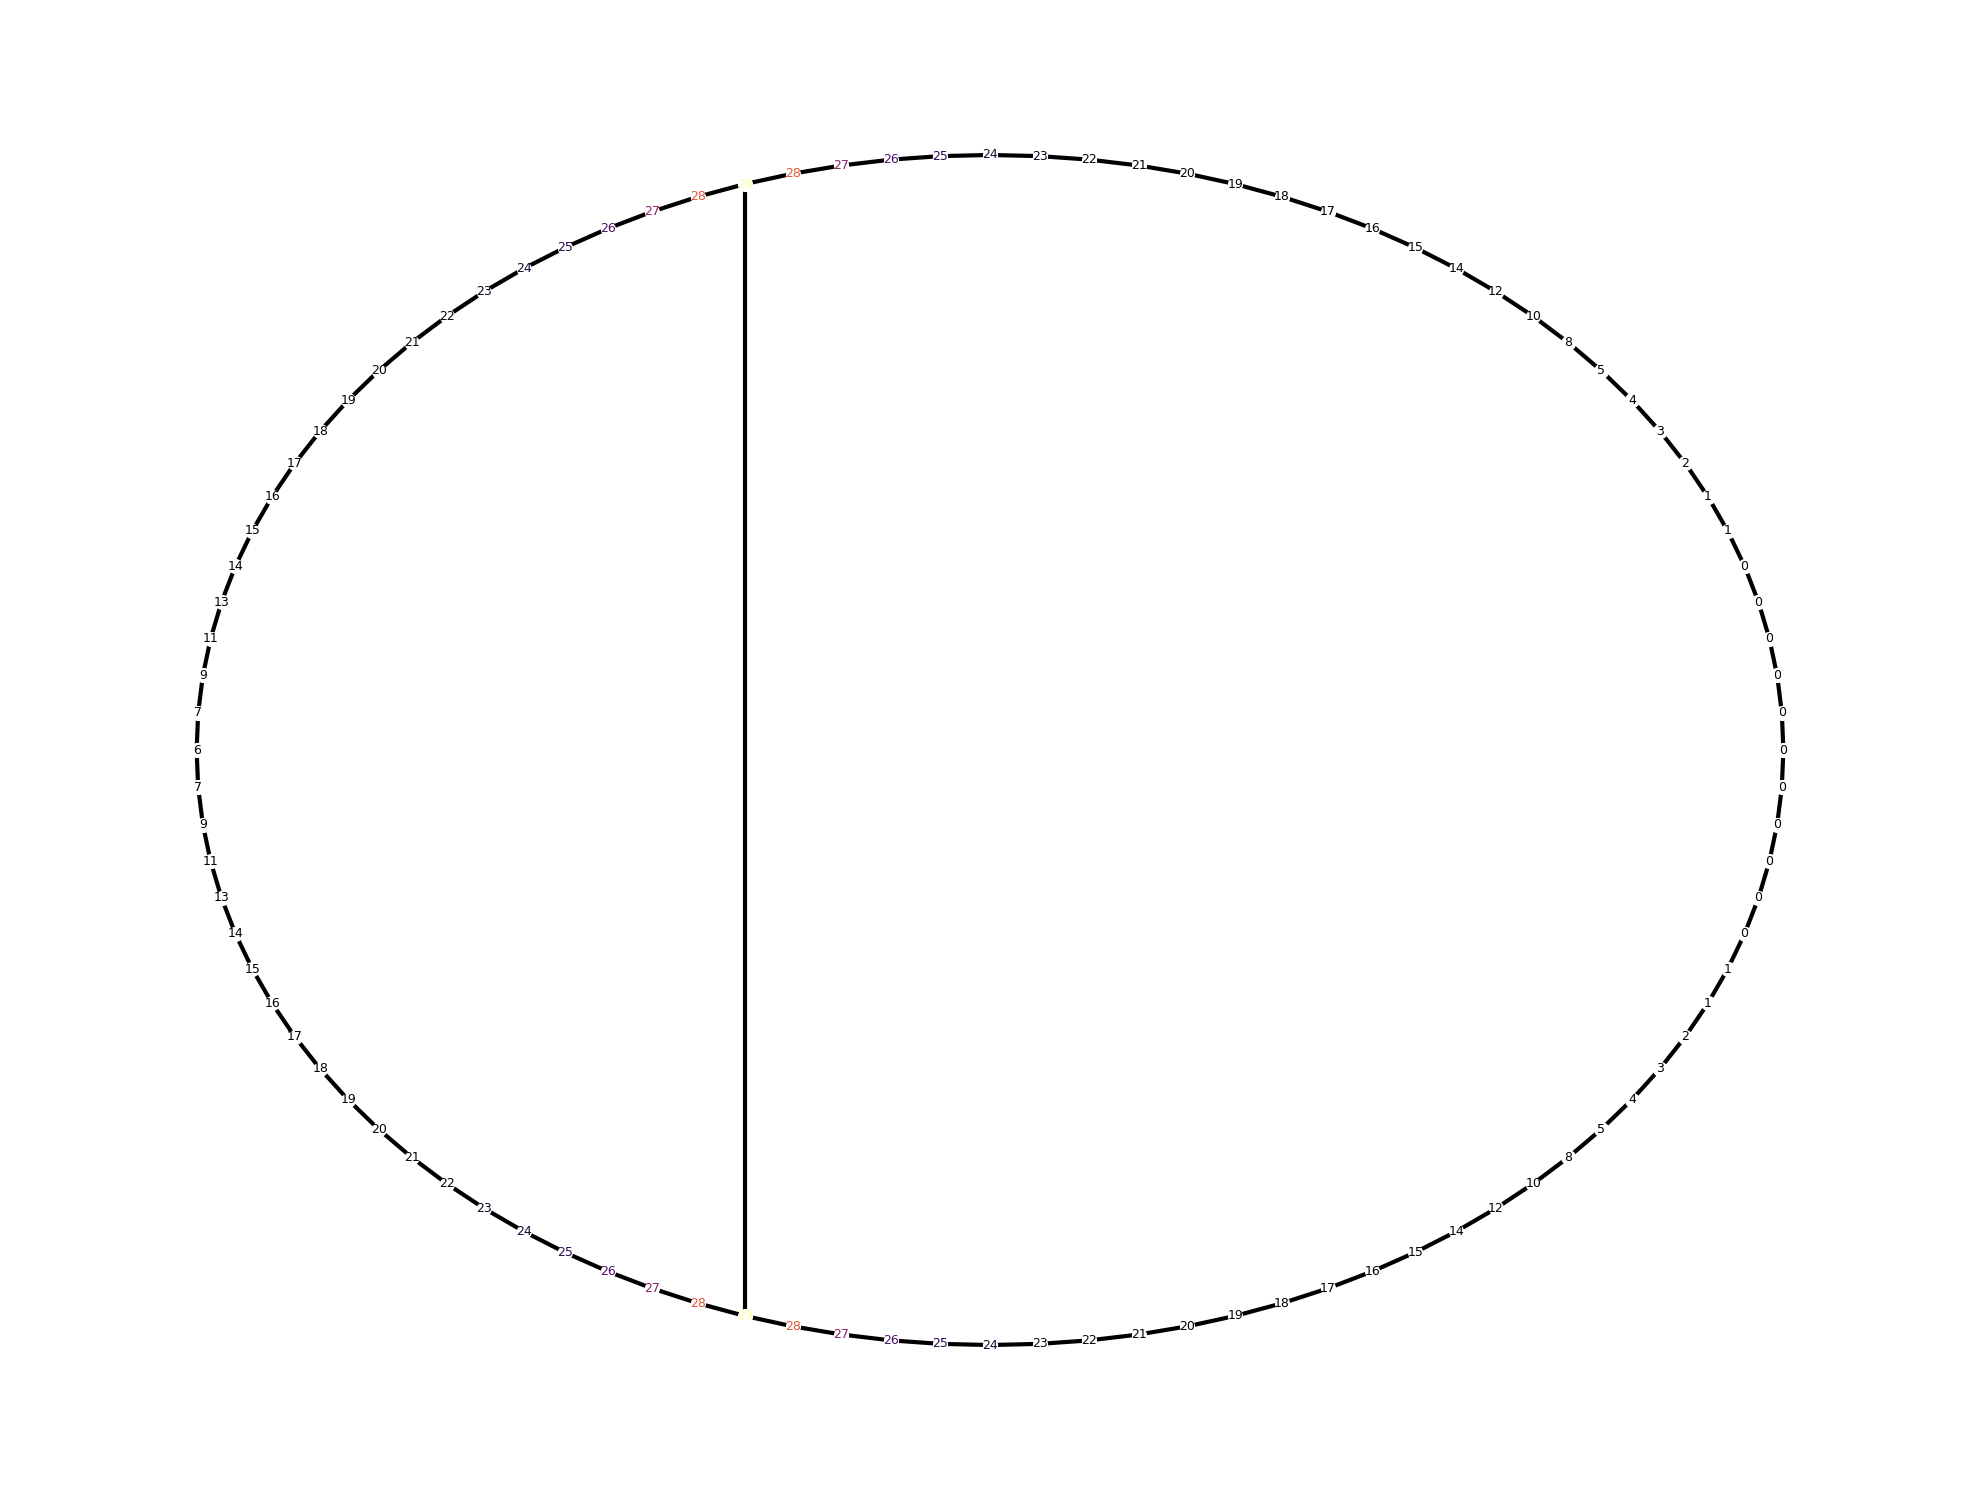

C:\Users\EMJ7FE\AppData\Local\Temp\ipykernel_9132\2428387005.py:60: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



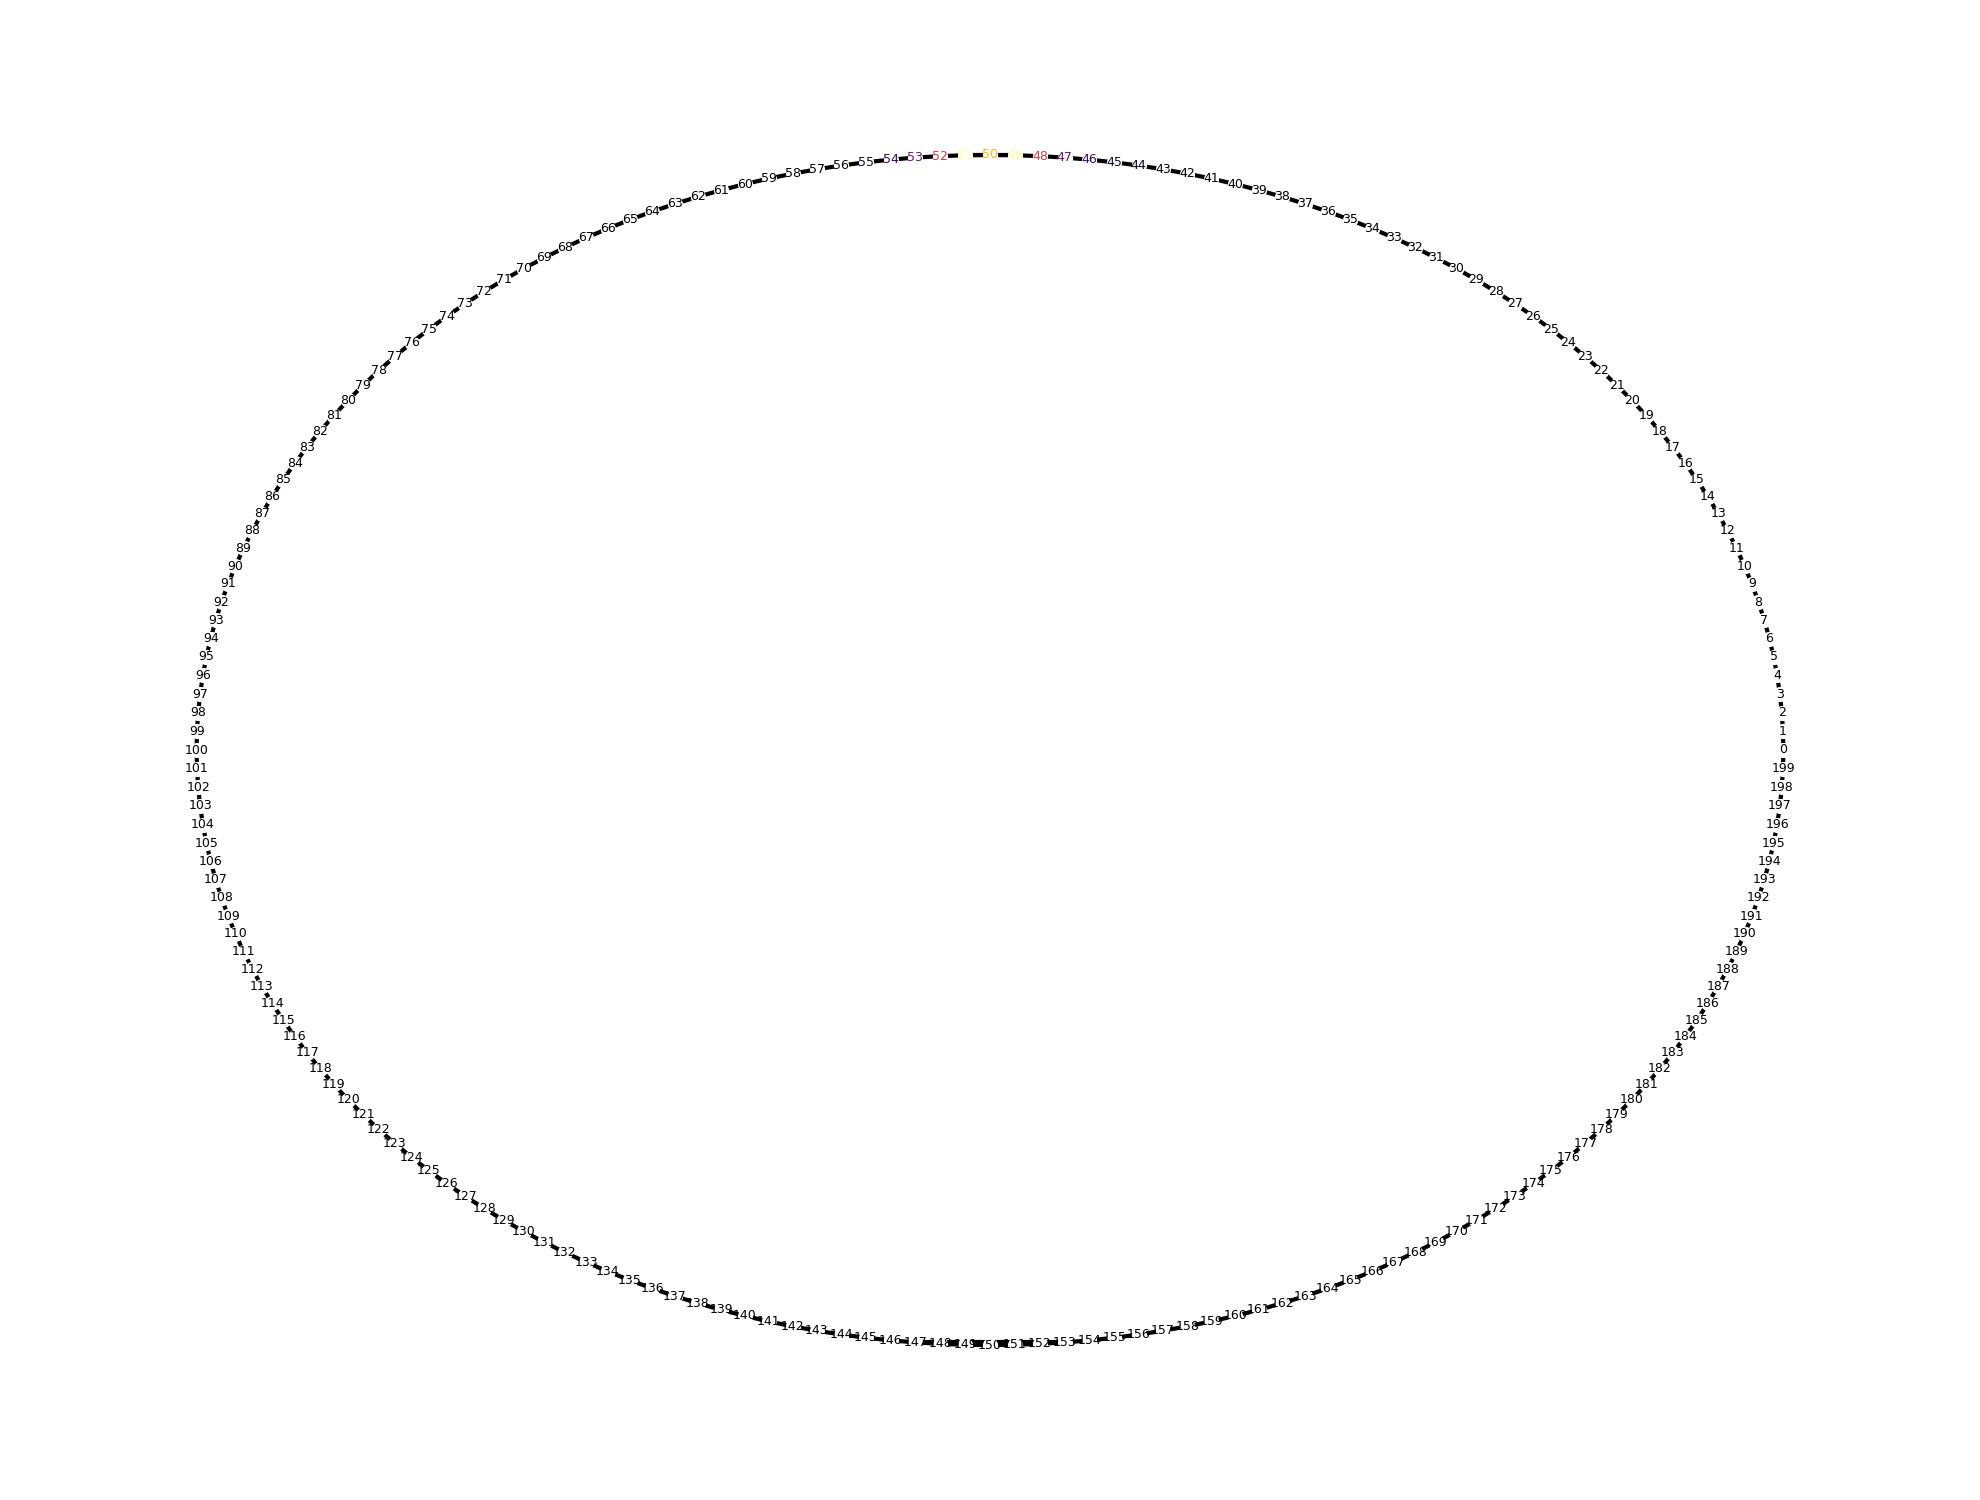

In [22]:
# What happens here is that the dominant vector switches
# My theorem only proofs that the CURRENT dominant vector (like the fixed one) changes pertubatively - it doesnt make a statement on whether another eigenvector can become the new "king"

# (A' - lam) = (A - Pperp (A' - A) Pperp - lam) x = Pperp (A' - A) Pperp x

G = nx.cycle_graph(100)
G.add_edges_from([
    (50-20, 50+20), # edge used to build a triangle
])
A_G = nx.adjacency_matrix(G).astype(np.float64)  # Get the adjacency matrix as a sparse matrix
lam_G, x = largest_eigen(A_G)
_, max_degree = max(G.degree(), key=lambda pair: pair[1])
spectral_gap = eigen_gap(A_G)

print("Dominant eigenvalue:", lam_G)
print("spectral_gap", spectral_gap)

colors, centroids = optimal1dclustering.cluster(
    x, k=30, mode=2, min_cluster_size=1
)
colors = np.array(colors)
clusterLoss = calculate_kmeans_cluster_loss(x, colors, centroids)
eigenvec_diff_norm_bound = 2*max_degree*clusterLoss / spectral_gap # provable approx upper bound
#eigenvec_diff_norm_bound = 2*lam_G*clusterLoss / spectral_gap # approx approx upper bound
#eigenvec_diff_norm_bound = lam_G*clusterLoss / spectral_gap # probably approx uppper bound tight


Ga = nx.cycle_graph(200)
Ga.add_edges_from([
    (50-1,50+1), # triangle
    (150-3, 150+3), # fixed because nest fixes it via colors
])
A_Ga = nx.adjacency_matrix(Ga).astype(np.float64)  # Get the adjacency matrix as a sparse matrix
lam_Ga, x_Ga = largest_eigen(A_Ga)
spectral_gap_Ga = eigen_gap(A_Ga)


# Plot G
graph = G
color_by = x
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
plt.figure(dpi=300)
norm = Normalize(vmin=color_by.min(), vmax=color_by.max())
cmap = plt.cm.get_cmap('inferno')
pos = nx.circular_layout(graph)
nx.draw(graph, pos, with_labels=False, font_size=3, node_size=7, node_color="white")
for i, (node, color_val) in enumerate(zip(graph.nodes, color_by)):
    plt.text(pos[node][0], pos[node][1], colors[node], fontsize=3, ha='center', va='center', color=cmap(norm(color_val)))
plt.show()


# Plot Ga
graph = Ga
color_by = x_Ga
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
plt.figure(dpi=300)
norm = Normalize(vmin=color_by.min(), vmax=color_by.max())
cmap = plt.cm.get_cmap('inferno')
pos = nx.circular_layout(graph)
#pos = nx.spring_layout(graph, iterations = 1000, seed = 17)
nx.draw(graph, pos, with_labels=False, font_size=3, node_size=7, node_color="white")
for i, (node, color_val) in enumerate(zip(graph.nodes, color_by)):
    plt.text(pos[node][0], pos[node][1], str(node), fontsize=3, ha='center', va='center', color=cmap(norm(color_val)))
    #plt.text(pos[node][0], pos[node][1], str(node), fontsize=3, ha='center', va='center', color=cmap(norm(color_val)))
plt.show()





# graphs to test
- reynold erneys
- power law graphs
- expander graphs 
- cliques
- trees and cliques that are d-regular
- graphs with large eigengap and ones with small
- real world graphs
- try to design a graph for which the number of alive sub colographs only sinks extremely slowly
- always test with different min_cluster sizes